In [ ]:
### Validation on Unseen data



In [2]:
from __future__ import print_function


import os
import glob
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from vit_pytorch.vivit import ViT
from train import VideoDataset, data_transform
torch.device('cpu')

device(type='cpu')

In [3]:
root_dir    = './dataset/unseen_validation_data/'
val_dir     = os.path.join(root_dir, 'validation')
val_dataset     = VideoDataset(val_dir, transform=data_transform)


validation_dataloader   = DataLoader(val_dataset, batch_size=1, shuffle=True)

In [4]:
model = ViT(
        image_size = (240,320),          # image size - height and width
        frames = 5,                    # number of frames
        image_patch_size = (80,80),      # image patch size
        frame_patch_size = 5,           # frame patch size
        num_classes = 2,
        dim = 64,
        spatial_depth = 4,               # depth of the spatial transformer
        temporal_depth = 4,              # depth of the temporal transformer
        heads = 4,
        mlp_dim = 128
    )



In [5]:
### Read all files in the checkpoint folder that start with 'checkpoint'
checkpoint_folder = './checkpoints'

checkpoint_files = glob.glob(f"{checkpoint_folder}/checkpoint*.pt")

In [6]:



## Calculate validation losses and accuracy along with epoch stamp

validation_losses = []
validation_accuracy = []
epochs = []
train_losses = []
test_losses = []
test_accuracy = []

for checkpoint_file in checkpoint_files:

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_file)
    
    # Extract the loss values and epoch from the checkpoint
    checkpoint_train_losses  = checkpoint['train_loss']
    checkpoint_test_losses   = checkpoint['test_loss']
    checkpoint_test_accuracy = checkpoint['test_accuracy']

    checkpoint_epochs = checkpoint['epoch']
    
    # Append the loss values and epochs to the respective lists
    train_losses.append(checkpoint_train_losses)
    test_losses.append(checkpoint_test_losses)
    test_accuracy.append(checkpoint_test_accuracy)
    epochs.append(checkpoint_epochs)

criterion = nn.CrossEntropyLoss()


for checkpoint_file in checkpoint_files:

    # Load the checkpoint
    checkpoint  = torch.load(checkpoint_file)
    checkpoint_epochs = checkpoint['epoch']


    model.load_state_dict(checkpoint['model_state_dict'])

    
    model.eval()  # Set the model to evaluation mode
    
    # Initialize variables to keep track of accuracy and loss
    total_samples = 0
    correct_predictions = 0
    total_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
    
    
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
    
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            total_loss += loss.item()
    
    # Calculate accuracy and loss
    accuracy = correct_predictions / total_samples
    average_loss = total_loss / len(validation_dataloader)
    epochs.append(checkpoint_epochs)
    validation_losses.append(average_loss)
    validation_accuracy.append(accuracy)
    print(f"Validation Loss: {average_loss:.4f}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")

    # Save validation loss and accuracy to the checkpoint
    checkpoint['validation_loss'] = average_loss
    checkpoint['validation_accuracy'] = accuracy
    
    # Save the updated checkpoint
    torch.save(checkpoint, checkpoint_file)



Validation Loss: 0.0010
Validation Accuracy: 100.00%
Validation Loss: 0.3766
Validation Accuracy: 76.19%
Validation Loss: 0.0003
Validation Accuracy: 100.00%
Validation Loss: 0.0002
Validation Accuracy: 100.00%
Validation Loss: 0.0007
Validation Accuracy: 100.00%
Validation Loss: 0.0002
Validation Accuracy: 100.00%
Validation Loss: 0.0045
Validation Accuracy: 100.00%
Validation Loss: 0.0004
Validation Accuracy: 100.00%
Validation Loss: 0.0016
Validation Accuracy: 100.00%
Validation Loss: 0.6461
Validation Accuracy: 66.67%
Validation Loss: 0.0005
Validation Accuracy: 100.00%


In [8]:
## Sort the lists according to epochs 


# Zip the lists together based on epochs
zipped_data = list(zip(validation_losses, validation_accuracy, test_accuracy, epochs))

# Sort the zipped data based on epochs (ascending order)
zipped_data.sort(key=lambda x: x[-1])  # Assuming epochs are the last element in the tuple

# Unzip the sorted data back into separate lists
validation_losses, validation_accuracy, test_accuracy, epochs = zip(*zipped_data)

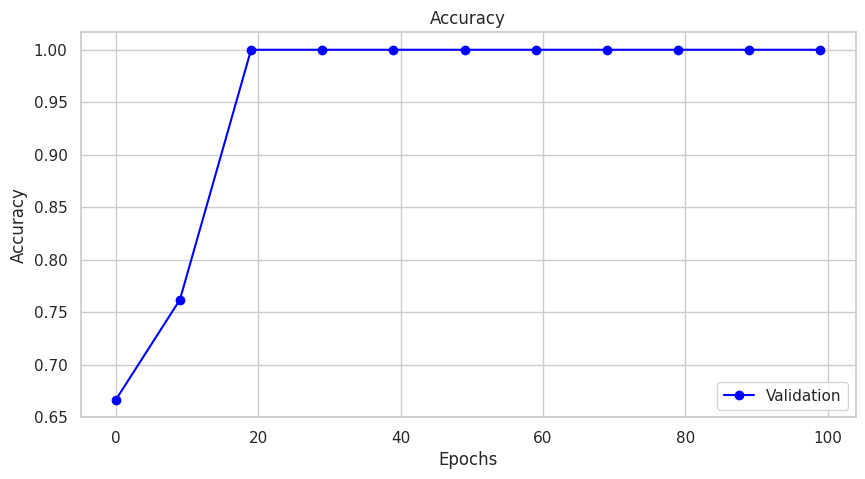

In [16]:
# Plot validation accuracy vs epochs
import matplotlib.pyplot as plt
import seaborn as sns


# Plot the loss curve
plt.rcParams["font.family"] = "Times New Roman"

sns.set_theme(style='whitegrid', palette='deep', font_scale=1, color_codes=True, rc=None)

plt.figure(figsize=(10, 5))
plt.plot(epochs, validation_accuracy, label='Validation', marker='o',color='blue')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
#plt.savefig('./assets/accuracy.jpg')
plt.show()